In [1]:
ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [2]:
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

In [5]:

# from caas_jupyter_tools import #display_dataframe_to_user

# If sympy is needed for Hill:
try:
    from sympy import Matrix
except Exception:
    Matrix = None

In [ ]:


# ----------------------------
# Shared metric functions
# ----------------------------
_eps = 1e-12
def _entropy_from_counts(counts, base=2):
    total = sum(counts.values())
    if total == 0: return 0.0
    H = 0.0
    for v in counts.values():
        p = v/total
        if p>0:
            H -= p * math.log(p, base)
    return H

def jensen_shannon_divergence(p_counts, q_counts, base=2):
    all_keys = set(p_counts.keys()) | set(q_counts.keys())
    Np, Nq = sum(p_counts.values()) or 1, sum(q_counts.values()) or 1
    m = {}
    for k in all_keys:
        m[k] = (p_counts.get(k,0)/Np + q_counts.get(k,0)/Nq) / 2.0
    kl_pm = 0.0; kl_qm = 0.0
    for k in all_keys:
        p = p_counts.get(k,0)/Np; q = q_counts.get(k,0)/Nq; mm = m[k]
        if p>0: kl_pm += p * math.log((p+_eps)/(mm+_eps), base)
        if q>0: kl_qm += q * math.log((q+_eps)/(mm+_eps), base)
    return 0.5*(kl_pm+kl_qm)

def mutual_information_pairs(pairs, base=2):
    N = len(pairs)
    if N==0: return 0.0
    joint = Counter(pairs)
    X = Counter(x for x,_ in pairs); Y = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y),n in joint.items():
        p_xy = n/N; p_x = X[x]/N; p_y = Y[y]/N
        mi += p_xy * math.log((p_xy+_eps)/(p_x*p_y+_eps), base)
    return mi

def confusion_jsd_avg(cipher_fun, plaintext, keyspace, sample_pairs=200, base=2):
    if len(keyspace) < 2: return 0.0
    total = 0.0; count = 0
    # If keyspace small, enumerate pairs; else sample
    for _ in range(sample_pairs):
        k1, k2 = random.sample(keyspace, 2)
        c1 = cipher_fun(plaintext, k1)
        c2 = cipher_fun(plaintext, k2)
        total += jensen_shannon_divergence(Counter(c1), Counter(c2), base=base)
        count += 1
    return total/count if count else 0.0

def diffusion_via_bigram_leakage(cipher_fun, plaintext, key, base=2):
    pt = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    grams = [pt[i:i+2] for i in range(len(pt)-1)]
    if not grams:
        return 0.0
    C = cipher_fun(pt, key)
    L = min(len(grams), len(C))
    pairs = [(grams[i], C[i]) for i in range(L)]
    mi = mutual_information_pairs(pairs, base=base)
    H = _entropy_from_counts(Counter(grams), base=base)
    return 1.0 - (mi / H if H > 0 else 0.0)

def cdci_linear(alpha, C, D): return alpha*C + (1.0-alpha)*D

def compute_cdci_for_cipher(cipher_func, plaintexts, fixed_key, keyspace, alpha=0.5, sample_pairs=200):
    Cs = []; Ds = []
    for pt in plaintexts:
        C_val = confusion_jsd_avg(cipher_func, pt, keyspace, sample_pairs=sample_pairs)
        D_val = diffusion_via_bigram_leakage(cipher_func, pt, fixed_key)
        Cs.append(C_val); Ds.append(D_val)
    C_mean = float(np.mean(Cs)); D_mean = float(np.mean(Ds))
    return {'C':C_mean, 'D':D_mean, 'CDCI': cdci_linear(alpha, C_mean, D_mean), 'C_per_plain': Cs, 'D_per_plain': Ds}

# Generic helper metrics reused in each block
def fraction_changed(a, b):
    L = min(len(a), len(b))
    return sum(x!=y for x,y in zip(a[:L], b[:L])) / L if L else 0.0

def symbol_diffusion_index(cipher_func, plaintext, key, alphabet, trials=20):
    base_ct = cipher_func(plaintext, key)
    results = []
    pt_filtered = "".join(ch for ch in plaintext.upper() if ch.isalnum())
    if len(pt_filtered) == 0:
        return 0.0, 0.0
    for _ in range(trials):
        i = random.randrange(len(pt_filtered))
        new_char = random.choice([c for c in alphabet if c != pt_filtered[i]])
        P2 = pt_filtered[:i] + new_char + pt_filtered[i+1:]
        C2 = cipher_func(P2, key)
        results.append(fraction_changed(base_ct, C2))
    return float(np.mean(results)), float(np.std(results)) if len(results)>1 else 0.0

def compute_ksi(cipher_func, plaintext, key, key_variant):
    C1 = cipher_func(plaintext, key)
    C2 = cipher_func(plaintext, key_variant)
    return fraction_changed(C1, C2)

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    conc_plain = "".join( "".join(ch for ch in p.upper() if ch.isalnum()) for p in plain_list )
    conc_cipher = "".join(cipher_list)
    L = min(len(conc_plain), len(conc_cipher))
    pairs = list(zip(conc_plain[:L], conc_cipher[:L]))
    return mutual_information_pairs(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    if N == 0: return 0.0, 0.0
    counts = Counter(text)
    expected = N / len(alphabet)
    chi2 = sum((counts[a] - expected)**2 / expected for a in alphabet)
    entropy = -sum((counts[a]/N) * math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=300, alpha=0.05):
    N = len(pairs)
    if N == 0: return 0.0, (0.0, 0.0)
    estimates = []
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        estimates.append(mutual_information_pairs(sample))
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high = estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low, high)

In [3]:
# ----------------------------
# 6) Hill cipher (n x n)
# ----------------------------
class HillCipher:
    def __init__(self, key, n):
        self.alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.char_to_num = {char: i for i, char in enumerate(self.alphabet)}
        self.num_to_char = {i: char for i, char in enumerate(self.alphabet)}
        self.n = n
        self.key = key
        self.key_matrix = self.getKeyMatrix(key, n)
        self.inverse_key_matrix = self.modMatInv(self.key_matrix, 26)

    def getKeyMatrix(self, key, n):
        k = 0
        keyMatrix = [[0] * n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                keyMatrix[i][j] = ord(key[k]) % 65
                k += 1
        return np.array(keyMatrix)

    def padding(self, plaintext):
        plaintext = plaintext.replace(" ", "").upper()
        pad_len = (self.n - len(plaintext) % self.n) % self.n
        plaintext += 'X' * pad_len
        return plaintext, pad_len

    def encrypt(self, plaintext):
        plaintext, pad_len = self.padding(plaintext)
        blocks = np.array([[self.char_to_num[char]] for char in plaintext])
        plaintext_blocks = [blocks[i:i+self.n] for i in range(0, len(blocks), self.n)]
        ciphertext = ""
        for block in plaintext_blocks:
            encrypted_block = np.dot(self.key_matrix, block) % 26
            for num in encrypted_block:
                ciphertext += self.num_to_char[num[0]]
        return ciphertext, pad_len

    def modMatInv(self, matrix, modulus):
        M = Matrix(matrix)
        det = int(M.det()) % modulus
        if math.gcd(det, modulus) != 1:
            raise ValueError("Key matrix not invertible modulo {}".format(modulus))
        det_inv = pow(det, -1, modulus)
        adjugate = M.adjugate()
        return np.array((det_inv * adjugate) % modulus).astype(int)

    def decrypt(self, ciphertext, pad_len=0):
        blocks = np.array([[self.char_to_num[char]] for char in ciphertext])
        cipher_blocks = [blocks[i:i+self.n] for i in range(0, len(blocks), self.n)]
        decrypted_text = ""
        for block in cipher_blocks:
            decrypted_block = np.dot(self.inverse_key_matrix, block) % 26
            for num in decrypted_block:
                decrypted_text += self.num_to_char[num[0]]
        if pad_len > 0:
            decrypted_text = decrypted_text[:-pad_len]
        return decrypted_text

def random_hill_key(n=3):
    attempts = 0
    while True:
        attempts += 1
        chars = [random.choice(ALPH) for _ in range(n*n)]
        key_str = "".join(chars)
        try:
            _ = HillCipher(key_str, n)
            return key_str
        except Exception:
            if attempts > 5000:
                raise RuntimeError("Failed to generate invertible Hill key after many attempts")

def perturb_hill_key(key_str, n=3, max_trials=200):
    base = list(key_str)
    for _ in range(max_trials):
        k = base[:]
        pos = random.randrange(len(k))
        k[pos] = random.choice([c for c in ALPH if c != k[pos]])
        cand = "".join(k)
        try:
            _ = HillCipher(cand, n)
            return cand
        except Exception:
            continue
    for _ in range(max_trials):
        k = base[:]
        i,j = random.sample(range(len(k)),2)
        k[i],k[j] = k[j],k[i]
        cand = "".join(k)
        try:
            _ = HillCipher(cand, n)
            return cand
        except Exception:
            continue
    raise RuntimeError("Could not find invertible perturbed key")

def hill_encrypt_wrapper(plaintext, key_str, n=3):
    hc = HillCipher(key_str, n)
    C, pad = hc.encrypt(plaintext)
    return C
#fixed_key="GYBNQKURP"
def evaluate_hill(n=3, num_texts=5, length=200, fixed_key="ZIQLMXYRI", random_key_count=10, alpha=0.5):
    plaintexts = [ "".join(random.choice(ALPH) for _ in range(length)) for _ in range(num_texts) ]
    plaintexts[0] = ("AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality" * 6)[:length]
    keyspace = [random_hill_key(n) for _ in range(80)]

    fixed_metrics = {}
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
    for pt in plaintexts:
        sm,ss = symbol_diffusion_index(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, fixed_key, ALPH)
        sdi_vals.append(sm)
        try:
            pert = perturb_hill_key(fixed_key, n=n)
        except Exception:
            pert = fixed_key
        ksi_vals.append(compute_ksi(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, fixed_key, pert))
        C = hill_encrypt_wrapper(pt, fixed_key, n)
        mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
        chi_vals.append(chi); ent_vals.append(H)
        pairs = list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)]))
        mb,_ = bootstrap_mi(pairs, n_boot=150); mi_boot.append(mb)

    cdci_out = compute_cdci_for_cipher(lambda p,k: hill_encrypt_wrapper(p,k,n), plaintexts, fixed_key, keyspace, alpha=alpha)
    fixed_metrics.update({
        'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals), 'MI_mean': np.mean(mi_vals),
        'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals), 'MI_boot_mean': np.mean(mi_boot),
        'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
    })
    fixed_df = pd.DataFrame([fixed_metrics])

    random_keys = [random_hill_key(n) for _ in range(random_key_count)]
    rand_records=[]
    for rk in random_keys:
        sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; ent_vals=[]; mi_boot=[]
        for pt in plaintexts:
            sm,ss = symbol_diffusion_index(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, rk, ALPH)
            sdi_vals.append(sm)
            try:
                pert = perturb_hill_key(rk, n=n)
            except Exception:
                pert = rk
            ksi_vals.append(compute_ksi(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, rk, pert))
            C = hill_encrypt_wrapper(pt, rk, n)
            mi_vals.append(compute_mi_from_plain_cipher_lists([pt],[C])); chi,H = compute_chi_entropy([C], ALPH)
            chi_vals.append(chi); ent_vals.append(H)
            pairs = list(zip("".join(ch for ch in pt.upper() if ch.isalnum()), C[:len(pt)]))
            mb,_ = bootstrap_mi(pairs, n_boot=120); mi_boot.append(mb)
        cdci_out = compute_cdci_for_cipher(lambda p,k: hill_encrypt_wrapper(p,k,n), plaintexts, rk, keyspace, alpha=alpha)
        rand_records.append({
            'key': rk, 'SDI_mean': np.mean(sdi_vals), 'KSI_mean': np.mean(ksi_vals),
            'MI_mean': np.mean(mi_vals), 'Chi2_mean': np.mean(chi_vals), 'Entropy_mean': np.mean(ent_vals),
            'MI_boot_mean': np.mean(mi_boot), 'C': cdci_out['C'], 'D': cdci_out['D'], 'CDCI': cdci_out['CDCI']
        })
    random_df = pd.DataFrame(rand_records)
    summary = pd.DataFrame({
        'mode':['fixed','random_mean'],
        'SDI_mean':[fixed_metrics['SDI_mean'], random_df['SDI_mean'].mean()],
        'KSI_mean':[fixed_metrics['KSI_mean'], random_df['KSI_mean'].mean()],
        'MI_mean':[fixed_metrics['MI_mean'], random_df['MI_mean'].mean()],
        'Entropy_mean':[fixed_metrics['Entropy_mean'], random_df['Entropy_mean'].mean()],
        'CDCI':[fixed_metrics['CDCI'], random_df['CDCI'].mean()],
        'C_index':[fixed_metrics['C'], random_df['C'].mean()],
        'D_index':[fixed_metrics['D'], random_df['D'].mean()]
    })

    #display_dataframe_to_user("Hill - Fixed", fixed_df)
    #display_dataframe_to_user("Hill - Random", random_df)
    #display_dataframe_to_user("Hill - Summary", summary)

    # plots
    x = np.arange(len(summary)); width=0.25
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x-width, summary['CDCI'], width, label='CDCI')
    ax.bar(x, summary['C_index'], width, label='C-index')
    ax.bar(x+width, summary['D_index'], width, label='D-index')
    ax.set_xticks(x); ax.set_xticklabels(summary['mode']); ax.set_ylabel('Score'); ax.set_title('Hill: CDCI / C / D'); ax.legend(); plt.show()

    # fixed_df.to_csv('../mnt/data/hill_fixed.csv', index=False)
    # random_df.to_csv('../mnt/data/hill_random.csv', index=False)
    # summary.to_csv('../mnt/data/hill_summary.csv', index=False)
    print("Hill saved to ./mnt/data/hill_*.csv")
    return fixed_df, random_df, summary

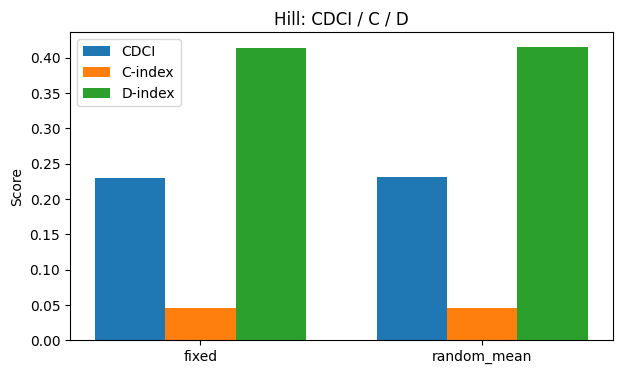

Hill saved to ./mnt/data/hill_*.csv


(   SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  MI_boot_mean  \
 0  0.014826  0.306468  1.778524  18.874627      4.627832      2.298299   
 
           C         D      CDCI  
 0  0.045386  0.413235  0.229311  ,
          key  SDI_mean  KSI_mean   MI_mean  Chi2_mean  Entropy_mean  \
 0  GLXUGPJVZ  0.014826  0.311443  1.760671  27.308458      4.601967   
 1  BPQSBJRTD  0.014776  0.316418  1.806938  24.566169      4.613728   
 2  PBYPRTUFT  0.014876  0.313433  1.740075  29.999005      4.594821   
 3  HTJPGHXVW  0.014826  0.307463  1.782342  21.668657      4.619808   
 4  PLTXKYPPI  0.014876  0.312438  1.785462  23.479602      4.616695   
 5  HECTTRMIL  0.014677  0.318408  1.906713  25.135323      4.607803   
 6  UBHIJCLLZ  0.014627  0.315423  1.798377  26.532338      4.600075   
 7  YBRVFFGIP  0.014328  0.316418  1.828886  18.305473      4.631310   
 8  GURMRODUH  0.014577  0.311443  1.811045  20.737313      4.625693   
 9  PQWOTAMQB  0.013035  0.313433  2.058928  26.791045   

In [4]:
evaluate_hill()


In [6]:
def measure_positional_diffusion(cipher_object, plaintext, num_trials=50):
    """
    Measures the positional predictability of changes in ciphertext.
    A lower score indicates more predictable changes (poor diffusion).
    """
    original_ciphertext, _ = cipher_object.encrypt(plaintext)
    cipher_len = len(original_ciphertext)
    
    changed_positions_all = []
    
    for _ in range(num_trials):
        # Create an incremental plaintext change
        modified_plaintext = list(plaintext)
        pos = random.randint(0, len(plaintext) - 1)
        modified_plaintext[pos] = random.choice(cipher_object.alphabet)
        modified_plaintext = "".join(modified_plaintext)
        
        try:
            modified_ciphertext, _ = cipher_object.encrypt(modified_plaintext)
        except Exception:
            continue
        
        changed_positions = [i for i, (c1, c2) in enumerate(zip(original_ciphertext, modified_ciphertext)) if c1 != c2]
        changed_positions_all.extend(changed_positions)
    
    if not changed_positions_all:
        return 0.0 # No changes were detected
    
    # Calculate a measure of distribution (e.g., variance of position indices)
    # A high variance indicates changes are scattered, low variance indicates clustering
    variance = np.var(changed_positions_all)
    
    # Normalize the score (you can adjust this formula)
    max_possible_variance = (cipher_len**2 - 1) / 12 # Variance of a uniform distribution
    normalized_score = variance / max_possible_variance
    
    return normalized_score

# Example Usage
# hill_cipher_obj = HillCipher(key="YOURKEY", n=3)
# score = measure_positional_diffusion(hill_cipher_obj, "ATTACKATDAWN")
# print(f"Positional Diffusion Score: {score:.2f}")

def measure_value_confusion(cipher_object, plaintext, num_trials=50):
    """
    Measures the predictability of the character values that change.
    A lower score indicates more predictable changes (poor confusion).
    """
    original_ciphertext, _ = cipher_object.encrypt(plaintext)
    value_differences_all = []
    
    original_key = cipher_object.key
    
    for _ in range(num_trials):
        # Create an incremental key change
        modified_key = list(original_key)
        pos = random.randint(0, len(original_key) - 1)
        modified_key[pos] = random.choice(cipher_object.alphabet)
        modified_key = "".join(modified_key)
        
        try:
            modified_cipher_obj = HillCipher(key=modified_key, n=cipher_object.n)
            modified_ciphertext, _ = modified_cipher_obj.encrypt(plaintext)
        except (ValueError, IndexError):
            continue
            
        # Calculate the numerical difference for changed characters
        diffs = [
            abs(cipher_object.char_to_num[c1] - cipher_object.char_to_num[c2])
            for c1, c2 in zip(original_ciphertext, modified_ciphertext) if c1 != c2
        ]
        value_differences_all.extend(diffs)
    
    if not value_differences_all:
        return 0.0 # No changes were detected
        
    # Calculate a measure of uniformity or randomness, like normalized entropy
    # A high entropy indicates a wide, unpredictable range of changes
    counts = Counter(value_differences_all)
    probabilities = np.array(list(counts.values())) / len(value_differences_all)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    max_entropy = np.log2(len(set(value_differences_all)))
    if max_entropy == 0:
        return 0.0
        
    normalized_entropy = entropy / max_entropy
    
    return normalized_entropy

# Example Usage
hill_cipher_obj = HillCipher(key="ZIQLMXYRI", n=3)
value_confusion_score = measure_value_confusion(hill_cipher_obj, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality")
print(f"Character Value Confusion Score: {value_confusion_score:.2f}")

Character Value Confusion Score: 0.88


In [6]:
positional_diffusion_score = measure_positional_diffusion(hill_cipher_obj, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality")
print(f"Positional Diffusion Score: {positional_diffusion_score:.2f}")

Positional Diffusion Score: 1.29


In [7]:

num = 2*value_confusion_score*positional_diffusion_score
din = value_confusion_score + positional_diffusion_score
DC = num / din
print(f"DC Score: {DC:.2f}")

DC Score: 1.05


In [7]:
hill_cipher_obj_1 = HillCipher(key="ZIQLMXYRI", n=3)
value_confusion_score = measure_value_confusion(hill_cipher_obj, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality",num_trials=100)
print(f"Character Value Confusion Score: {value_confusion_score:.2f}")
positional_diffusion_score = measure_positional_diffusion(hill_cipher_obj_1, "AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality",num_trials=100)
print(f"Positional Diffusion Score: {positional_diffusion_score:.2f}")

Character Value Confusion Score: 0.88
Positional Diffusion Score: 1.10


In [8]:
num = 2*value_confusion_score*positional_diffusion_score
din = value_confusion_score + positional_diffusion_score
DC = num / din
print(f"DC Score: {DC:.2f}")

DC Score: 0.98


In [ ]:
#plaintext - AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality
# Character Value Confusion Score: 0.88
# Positional Diffusion Score: 1.29
# DC Score: 1.05

In [ ]:
# num_trials = 100
#plaintext - AdistributedsystemisacollectionofindependententitiesthatcooperatetosolveaproblemthatcannotbeindividuallysolvedDistributedsystemshavebeeninexistencesincethestartoftheuniverseFromaschooloffishtoaflockofbirdsandentireecosystemsofmicroorganismsthereiscommunicationamongmobileintelligentagentsinnatureWiththewidespreadproliferationoftheinternetandtheemergingglobalvillagethenotionofdistributedcomputingsystemsasausefulandwidelydeployedtoolisbecomingareality
# Character Value Confusion Score: 0.88
# Positional Diffusion Score: 1.10
# DC Score: 0.98